In [1]:
import math
import numpy as np
import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from scipy.special import expit

from numpy.random import default_rng

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import time

from gaAnn_thread_V_I import *



class MultiLayerPerceptron():
    # ================== Activation Functions ================ #

    # accepts a vector or list and returns a list after performing corresponding function on all elements

    @staticmethod
    def sigmoid(vectorSig):
        """returns 1/(1+exp(-x)), where the output values lies between zero and one"""
        sig = expit(vectorSig)
        return sig

    @staticmethod
    def binaryStep(x):
        """ It returns '0' is the input is less then zero otherwise it returns one """
        return np.heaviside(x, 1)

    @staticmethod
    def linear(x):
        """ y = f(x) It returns the input as it is"""
        return x

    @staticmethod
    def tanh(x):
        """ It returns the value (1-exp(-2x))/(1+exp(-2x)) and the value returned will be lies in between -1 to 1"""
        return np.tanh(x)

    @staticmethod
    def relu(x):  # Rectified Linear Unit
        """ It returns zero if the input is less than zero otherwise it returns the given input"""
        x1 = []
        for i in x:
            if i < 0:
                x1.append(0)
            else:
                x1.append(i)

        return x1

    @staticmethod
    def leakyRelu(x):
        """ It returns zero if the input is less than zero otherwise it returns the given input"""
        x1 = []
        for i in x:
            if i < 0:
                x1.append((0.01 * i))
            else:
                x1.append(i)

        return x1

    @staticmethod
    def parametricRelu(self, a, x):
        """ It returns zero if the input is less than zero otherwise it returns the given input"""
        x1 = []
        for i in x:
            if i < 0:
                x1.append((a * i))
            else:
                x1.append(i)

        return x1

    @staticmethod
    def softmax(self, x):
        """ Compute softmax values for each sets of scores in x"""
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # ============ Activation Functions Part Ends ============= #

    # ================= Distance Calculation ================== #

    @staticmethod
    def chebishev(self, cord1, cord2, exponent_h):
        dist = 0.0
        if ((type(cord1) == int and type(cord2) == int) or ((type(cord1) == float and type(cord2) == float))):
            dist = math.pow((cord1 - cord2), exponent_h)
        else:
            for i, j in zip(cord1, cord2):
                dist += math.pow((i - j), exponent_h)
        dist = math.pow(dist, (1.0 / exponent_h))
        return dist

    @staticmethod
    def minimum_distance(self, cord1, cord2):
        # min(|x1-y1|, |x2-y2|, |x3-y3|, ...)
        dist = float('inf')
        if ((type(cord1) == int and type(cord2) == int) or ((type(cord1) == float and type(cord2) == float))):
            dist = math.fabs(cord1 - cord2)
        else:
            for i, j in zip(cord1, cord2):
                temp_dist = math.fabs(i - j)
                if (temp_dist < dist):
                    dist = temp_dist
        return dist

    @staticmethod
    def maximum_distance(self, cord1, cord2):
        # max(|x1-y1|, |x2-y2|, |x3-y3|, ...)
        dist = float('-inf')
        if ((type(cord1) == int and type(cord2) == int) or ((type(cord1) == float and type(cord2) == float))):
            dist = math.fabs(cord1 - cord2)
        else:
            for i, j in zip(cord1, cord2):
                temp_dist = math.fabs(i - j)
                if (temp_dist > dist):
                    dist = temp_dist
        return dist

    @staticmethod
    def manhattan(self, cord1, cord2):
        # |x1-y1| + |x2-y2| + |x3-y3| + ...
        dist = 0.0
        if ((type(cord1) == int and type(cord2) == int) or ((type(cord1) == float and type(cord2) == float))):
            dist = math.fabs(cord1 - cord2)
        else:
            for i, j in zip(cord1, cord2):
                dist += math.fabs(i - j)
        return dist

    @staticmethod
    def eucledian(self, cord1, cord2):
        dist = 0.0
        if ((type(cord1) == int and type(cord2) == int) or ((type(cord1) == float and type(cord2) == float))):
            dist = math.pow((cord1 - cord2), 2)
        else:
            for i, j in zip(cord1, cord2):
                dist += math.pow((i - j), 2)
        return math.pow(dist, 0.5)

    # =========== Distance Calculation Ends ============== #

    def __init__(self, dimensions=(8, 5), all_weights=(0.1, 0.2), fileName="iris"):

        """
        Args:
            dimensions : dimension of the neural network
            all_weights : the optimal weights we get from the bio-algoANN models
        """

        self.allPop_Weights = []
        self.allPopl_Chromosomes = []
        self.allPop_ReceivedOut = []
        self.allPop_ErrorVal = []

        self.all_weights = all_weights

        self.fitness = []

        # ================== Input dataset and corresponding output ========================= #

        self.fileName = fileName
        self.fileName += ".csv"
        data = pd.read_csv(self.fileName)

        classes = []
        output_values_expected = []
        input_values = []

        # ~~~~ encoding ~~~~#

        # labelencoder = LabelEncoder()
        # data[data.columns[-1]] = labelencoder.fit_transform(data[data.columns[-1]])

        # one hot encoding - for multi-column
        # enc = OneHotEncoder(handle_unknown='ignore')
        # combinedData = np.vstack((data[data.columns[-2]], data[data.columns[-1]])).T
        # print(combinedData)
        # y = enc.fit_transform(combinedData).toarray()
        # y = OneHotEncoder().fit_transform(combinedData).toarray()

        #
        y = LabelBinarizer().fit_transform(data[data.columns[-1]])
        # print(y)

        # ~~~~ encoding ends~~~~#

        for j in range(len(data)):
            output_values_expected.append(y[j])

        # print(output_values_expected)

        input_values = []
        for j in range(len(data)):
            b = []
            for i in range(1, len(data.columns) - 1):
                b.append(data[data.columns[i]][j])
            input_values.append(b)

        self.X = input_values[:]
        self.Y = output_values_expected[:]

        # input and output
        self.X = input_values[:]
        self.Y = output_values_expected[:]

        self.dimension = dimensions
        # print(self.dimension)

        # ================ Finding Initial Weights ================ #

        self.pop = []  # weights
        reshaped_all_weights = []
        start = 0
        for i in range(len(self.dimension) - 1):
            end = start + self.dimension[i + 1] * self.dimension[i]
            temp_arr = self.all_weights[start:end]
            w = np.reshape(temp_arr[:], (self.dimension[i + 1], self.dimension[i]))
            reshaped_all_weights.append(w)
            start = end
        self.pop.append(reshaped_all_weights)

        self.init_pop = self.all_weights

    # ================ Initial Weights Part Ends ================ #


    def Predict(self, chromo):
        # X, Y and pop are used
        self.fitness = []
        total_error = 0
        m_arr = []
        k1 = 0
        for i in range(len(self.dimension) - 1):
            p = self.dimension[i]
            q = self.dimension[i + 1]
            k2 = k1 + p * q
            m_temp = chromo[k1:k2]
            m_arr.append(np.reshape(m_temp, (p, q)))
            k1 = k2

        y_predicted = []
        for x, y in zip(self.X, self.Y):

            yo = x

            for mCount in range(len(m_arr)):
                yo = np.dot(yo, m_arr[mCount])
                yo = self.sigmoid(yo)
            
            # converting to sklearn acceptable form
            max_yo = max(yo)
            for y_vals in range(len(yo)):
                if(yo[y_vals] == max_yo):
                    yo[y_vals] = 1
                else:
                    yo[y_vals] = 0
            y_predicted.append(yo)
        return (y_predicted, self.Y)

    def main(self):
        Y_PREDICT, Y_ACTUAL = self.Predict(self.init_pop)
        Y_PREDICT = np.array(Y_PREDICT)
        Y_ACTUAL = np.array(Y_ACTUAL)
        
        n_classes = 3
        
        label_binarizer = LabelBinarizer()
        label_binarizer.fit(range(n_classes))
        Y_PREDICT = label_binarizer.inverse_transform(np.array(Y_PREDICT))
        Y_ACTUAL = label_binarizer.inverse_transform(np.array(Y_ACTUAL))
        
        # find error
        
        print("\n Actual / Expected", Y_ACTUAL)
        print("\n Predictions", Y_PREDICT)
        print("\n\nConfusion Matrix")
        print(confusion_matrix(Y_ACTUAL, Y_PREDICT))
        
        print("\n\nClassification Report")
        target_names = ['class 0', 'class 1', 'class 2']
        print(classification_report(Y_ACTUAL, Y_PREDICT, target_names=target_names))



Time for inputting data :  0.006978511810302734
============ Calling GA to get best weights ===============
--------------GENERATION 0-----------
--------------GENERATION 1-----------
--------------GENERATION 2-----------
--------------GENERATION 3-----------
--------------GENERATION 4-----------
--------------GENERATION 5-----------
--------------GENERATION 6-----------
--------------GENERATION 7-----------
--------------GENERATION 8-----------
--------------GENERATION 9-----------
--------------GENERATION 10-----------
--------------GENERATION 11-----------
--------------GENERATION 12-----------
--------------GENERATION 13-----------
--------------GENERATION 14-----------
--------------GENERATION 15-----------
--------------GENERATION 16-----------
--------------GENERATION 17-----------
--------------GENERATION 18-----------
--------------GENERATION 19-----------
--------------GENERATION 20-----------
--------------GENERATION 21-----------
--------------GENERATION 22-----------
-----

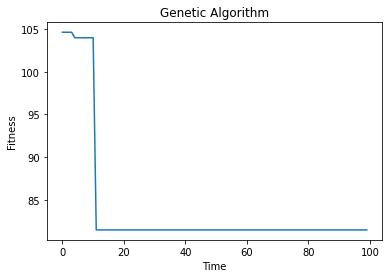

In [2]:
start_time = time.time()
i = InputData(fileName="../ANN/iris")
input_val, output_val = i.main()
end_time = time.time()
print("Time for inputting data : ", end_time - start_time)
        
print("============ Calling GA to get best weights ===============")

n_iterations = 100
e_rate = 0.1

start_time = time.time()
a = gaAnn(initialPopSize=100, m = 10, dimensions = [100,10], bestCount = 30, input_values=input_val , output_values_expected=output_val, iterations = n_iterations, elicitation_rate = e_rate)

fit, b, weights, dim = a.main()

end_time = time.time()
print("Time taken : ", end_time - start_time)

print("\n Fitness : ", fit, "\n Best Weights : ", weights, "\n Dimensions : ", dim)



import matplotlib.pyplot as plt
x=b[:]
z=[i for i in range(0,100)]
plt.plot(z,x)

plt.title("Genetic Algorithm")
plt.ylabel("Fitness")
plt.xlabel("Time")
end_time = time.time()
print("Time Taken : ", end_time - start_time)

In [3]:
print("\n\n============= MLP Program Begins ============")

start_time = time.time()
print("Training")
m = MultiLayerPerceptron(fileName="../ANN/iris_train", dimensions=dim, all_weights=weights)
m.main()
end_time = time.time()
print("Time taken = ", end_time - start_time)



============= MLP Program Begins ============
Training

 Actual / Expected [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]

 Predictions [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 2 0 1 1 0 1 2 1 1 1 1 1 2 1 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 0 2 1 2 2 1 1 1
 2 1 1 2 1 2 2 2 2]


Confusion Matrix
[[39  1  0]
 [11 27  2]
 [ 1 17 22]]


Classification Report
              precision    recall  f1-score   support

     class 0       0.76      0.97      0.86        40
     class 1       0.60      0.68      0.64        40
     class 2       0.92      0.55      0.69        40

    accuracy                           0.73       120
   macro avg       0.76      0.73      0.73       120
weighted avg 

In [4]:
start_time = time.time()
print("Testing")
m = MultiLayerPerceptron(fileName="../ANN/iris_test", dimensions=dim, all_weights=weights)
m.main()

end_time = time.time()
print("Time taken = ", end_time - start_time)

Testing

 Actual / Expected [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]

 Predictions [0 1 0 0 0 0 0 0 0 0 2 1 1 1 1 0 0 1 0 1 2 0 1 1 2 2 1 2 2 2]


Confusion Matrix
[[9 1 0]
 [3 6 1]
 [1 3 6]]


Classification Report
              precision    recall  f1-score   support

     class 0       0.69      0.90      0.78        10
     class 1       0.60      0.60      0.60        10
     class 2       0.86      0.60      0.71        10

    accuracy                           0.70        30
   macro avg       0.72      0.70      0.70        30
weighted avg       0.72      0.70      0.70        30

Time taken =  0.00698089599609375
